In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="llama-3.1-8b-instant")
result=llm.invoke("Hello")

print(result.content)

It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [18]:
from typing_extensions import Literal,TypedDict
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage


class Route(BaseModel):
    step:Literal["poem","story","joke"] = Field(description="the next step to take")

router= llm.with_structured_output(Route)

class State(TypedDict):
    ip:str
    decision:str
    op:str


# Nodes

def l1(state:State):
    """Handles the poem generation"""
    res=llm.invoke(state["ip"])
    return {"op":res.content}

def l2(state:State):
    """Handles the joke generation"""
    res=llm.invoke(state["ip"])
    return {"op":res.content}

def l3(state:State):
    """Handles the story generation"""
    res=llm.invoke(state["ip"])
    return {"op":res.content}


def llm_router(state:State):
    """Handles the routing part to which node to access next"""

    call=router.invoke([
        SystemMessage(content="Route the input to the right node"),
        HumanMessage(content=state["ip"])
    ])
    return {"decision":call.step}


def route_decision(state: State):
    if state["decision"] == "poem":
        return "poem"
    elif state["decision"] == "story":
        return "story"
    elif state["decision"] == "joke":
        return "joke"


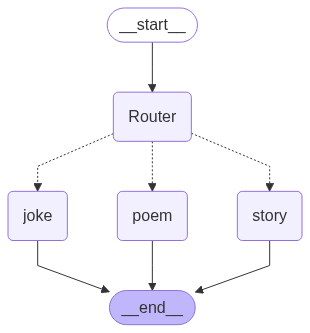

In [19]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
# Graph Building

builder = StateGraph(State)
builder.add_node("Router", llm_router)
builder.add_node("poem", l1)
builder.add_node("joke", l2)
builder.add_node("story", l3)


# Edges
builder.add_edge(START, "Router")
builder.add_conditional_edges(
    "Router",
    route_decision,
    {
        "poem": "poem",
        "joke": "joke",
        "story": "story"
    }
)

builder.add_edge("poem", END)
builder.add_edge("joke", END)
builder.add_edge("story", END)



graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
res=graph.invoke({"ip":"give a dialogue on fire and water"})

In [26]:
print(res["op"])

**Scene: A serene lake on a sunny afternoon. Two friends, Alex and Maya, are sitting on a wooden dock, watching the sunlight dance on the water.**

**Alex:** Maya, have you ever thought about how fire and water are two opposing forces in nature?

**Maya:** (nods) I have. It's like they're two sides of the same coin. Fire represents destruction and chaos, while water represents calmness and serenity.

**Alex:** Exactly. But what if I told you that fire and water aren't mutually exclusive? In fact, they can even complement each other.

**Maya:** (raises an eyebrow) How do you mean?

**Alex:** Think about it. Water can extinguish fire, but it can also be used to create steam, which can be used to power machines and generate energy. And have you ever seen a beautiful sunset over a body of water? The way the light from the fire dances on the water's surface is breathtaking.

**Maya:** (smiles) I see what you mean. Fire and water can work together to create something beautiful.

**Alex:** Ex